In [1]:
import astropy.units as u
import astropy.constants as cons
import numpy as np
import HERA_hack_FG
import FG_pygsm
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
def resample(data, out_x, out_y):
    '''resamples the input array to get the map to the desired total size
    
    data: 2D array to re-sample
    out_x, out_y: required size of the map (pixel units)
    '''
    y = np.linspace(0, 1.0, data.shape[0])
    x = np.linspace(0, 1.0, data.shape[1])
    fun = RegularGridInterpolator((y, x), data)

    yy, xx = np.meshgrid(np.linspace(0, 1.0, out_y), np.linspace(0, 1.0, out_x))

    return fun((xx, yy))

## Determine at which frequencies to make the maps -- from Adelie's $\textit{Specs.ipynb}$.

We are taking 150 channels centred at 150 MHz with a resolution of 100 kHz.

In [3]:
# 21cm rest-frame frequency
nu0 = 1420e6 * u.Hz
fmin, fmax = 106e6 * u.Hz, 196e6 * u.Hz
df = 100e3 * u.Hz
bandwidth = np.arange(fmin.value, fmax.value + df.value, step=df.value)
avg_nu = 150.e6 * u.Hz

nfreqs = 150
iavg = list(bandwidth).index(avg_nu.value)
spw_range = (iavg-150//2, iavg+150//2)
spw_window = bandwidth[spw_range[0]:spw_range[1]]

# converting to MHz since spw_window is in Hz
freqs = spw_window / 1e6

## Determine the corners of the field of view in polar coordinates.

This is required as an input to create an observation with $\textit{HERA_hack_FG}$.

In [4]:
# coordinates of the pointing centre
RA = 0*u.rad  # hr or rad
Dec = (-30*u.deg).to(u.rad) # rad

# converting centre to theta and phi coordinates in rad
x = np.cos(RA) * np.cos(Dec)
y = np.sin(RA) * np.cos(Dec)
z = np.sin(Dec)
theta0 = np.arctan(y/x)
phi0 = np.arccos(z / np.sqrt(x**2 + y**2 + z**2))

# getting pixel size in radians
npix_x = 2048
npix_y = 2048
pix_size = (16*u.arcsec).to(u.rad)

# getting the cornes of the field of view box in deg
phi_minus = (phi0 - (npix_y*pix_size)/2).to(u.deg).value
phi_plus = (phi0 + (npix_y*pix_size)/2).to(u.deg).value

theta_minus = (theta0 - (npix_x*pix_size)/2).to(u.deg).value
theta_plus = (theta0 + (npix_x*pix_size)/2).to(u.deg).value

In [5]:
# setting up the corners
acorner = np.array([[phi_minus, theta_minus],
                    [phi_plus, theta_plus],
                    [phi_minus, theta_plus],
                    [phi_plus, theta_minus]])

# the array configuration has no impact on making foreground maps from pyGSM, create random telescope config
dishes = np.array([[1,2],[2,1]])

latitude = -26.82472208 # deg
channel_width = 0.1 # 100 kHz in MHz
beam_width = 0.002  # deg

## Retrieve diffuse foregrounds from pyGSM at the defined field of view

In [6]:
pbeam = True 
norm = True 

# smaller map size for quicker computation
smaller_sizex = npix_x//10
smaller_sizey = npix_y//10

my_fake_telescope = HERA_hack_FG.telescope(dishes, 
                                           latitude=latitude, 
                                           channel_width=channel_width, 
                                           beam_width=beam_width, 
                                           beam='gaussian')

obs = HERA_hack_FG.observation(telescope=my_fake_telescope, 
                               n_days = 3, 
                               freq = freqs[len(freqs)//2], 
                               delta_t = 0.002 ,
                               corners = acorner, 
                               beam_sigma_cutoff=10, 
                               sky_shape = (smaller_sizex,smaller_sizey), 
                               norm = norm , 
                               pbeam = pbeam)

unresolved_sources_per_pixel = 200

fg = FG_pygsm.foregrounds(obs, unresolved_sources_per_pixel)
diffuse_fg = fg.diffuse_fg(150, pygsm = True)

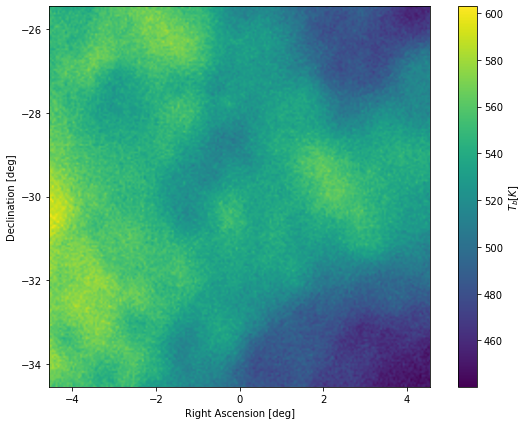

In [18]:
data = diffuse_fg.reshape(smaller_sizex,smaller_sizey)

# resampling to get 2048x2048 map
scaled_foregrounds = resample(data, npix_x, npix_y)

plt.figure(figsize=(10,7))
plt.imshow(scaled_foregrounds, extent=[theta_minus,theta_plus,90-phi_plus,90-phi_minus])
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.colorbar(label = r"$T_b [K]$")
plt.show()

In [20]:
# saving file - size ~ 33 MB

hdu = fits.PrimaryHDU(scaled_foregrounds)
hdu.writeto('diffuse_fg_{}MHz.fits'.format(freqs[len(freqs)//2]))